# Sparkify Capstone Project 

## Introduction:
In this project I will be looking at the Sparkify dataset provided by Udacity. This workspace contains a tiny subset (128MB) of the full dataset available (12GB).
I will load, clean and analyse this data set. I will then aim to create a machine learning model to predict churn (which is when a customer leaves the service). 

The references I used are given throughout (in comments)

## Importing libraries:

In [193]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import seaborn as sns
import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, desc, min, max, udf, isnull, sum, rank, split, when
from pyspark.sql.types import IntegerType, FloatType, StringType, ArrayType
from pyspark.sql.window import Window


from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Capstone Project") \
    .getOrCreate()

In [3]:
pd.set_option('display.max_colwidth', -1)

## Load and Clean Dataset
In this workspace, I will be using the mini-dataset file `mini_sparkify_event_data.json`. I will load and clean this dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Load the dataset:
df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
# Look at the size of the dataframe
print('The number of rows in the dataframe is: ' + str(df.count()))
print('The number of columns in the dataframe is: ' + str(len(df.columns)))

The number of rows in the dataframe is: 286500
The number of columns in the dataframe is: 18


In [6]:
# Take at columns:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Take a look at column types:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [8]:
# Creating a dataframe to check how many nulls/empties are in each column:

# First create a dictionary:
d = []
# Add rows to dictionary for each column:
for col in df.columns:
    d.append(
        {
            'Column Name': col,
            'Number of nulls': df.filter(isnull(df[col])).count(),
            'Number of Empty Strings': df.filter(df[col].isin('')).count()
        }
    )

#Show this as a pandas dataframe:
pd.DataFrame(d)

# Reference: https://stackoverflow.com/questions/28056171/how-to-build-and-fill-pandas-dataframe-from-for-loop

,Column Name,Number of Empty Strings,Number of nulls
0,artist,0,58392
1,auth,0,0
2,firstName,0,8346
3,gender,0,8346
4,itemInSession,0,0
5,lastName,0,8346
6,length,0,58392
7,level,0,0
8,location,0,8346
9,method,0,0


There are no nulls in sessionID or userID however userID does contain empty strings so we can remove those. We can leave the other nulls in

In [9]:
#remove record with null or empty string values
df = df.filter(df["userId"] != "")

In [10]:
df.count()

278154

We are left with 278,154 rows for our mini subset of data. I will now check to see if we should remove any other nulls:

In [11]:
df_pandas = df.toPandas()

In [12]:
df_pandas[df_pandas["artist"].isnull()]['page'].head(10)

8     Add to Playlist
11    Roll Advert    
14    Thumbs Up      
35    Downgrade      
44    Thumbs Up      
47    Thumbs Down    
51    Home           
53    Logout         
56    Thumbs Up      
57    Home           
Name: page, dtype: object

From this it makes sense why we may have nulls in some columns. For example the page 'Home' would not have any artist, song or length associated to it, so those fields are null. However, it is still important to keep in the dataset. Therefore I will keep the nulls in the dataset.

# Exploratory Data Analysis
I will be using the small subset of data to explore the data and do basic manipulations within spark

### Preliminary Analysis:
Doing some preliminary analysis will allow me understand the data and prepare it for the main bulk of analysis

In [13]:
# Look the data frame as a pandas frame
pd.DataFrame(df.take(5), columns=df.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30


In [14]:
# Look at page names to be used to define churn:
df_page_counts = df.groupby("page").count().withColumnRenamed('count','full count').sort(desc("full count")).toPandas()

# Reference: https://www.educba.com/pyspark-rename-column/

In [15]:
df_page_unique_counts = df.select(['userId', 'page']).dropDuplicates().groupBy('page').count()\
    .withColumnRenamed('count','unique user count').toPandas()

In [16]:
df_page_counts.merge(df_page_unique_counts, on='page', how='left')

,page,full count,unique user count
0,NextSong,228108,225
1,Thumbs Up,12551,220
2,Home,10082,223
3,Add to Playlist,6526,215
4,Add Friend,4277,206
5,Roll Advert,3933,207
6,Logout,3226,213
7,Thumbs Down,2546,203
8,Downgrade,2055,154
9,Settings,1514,195


In [17]:
print('Number of non null artist rows: ' + str(df.filter(~isnull(df['artist'])).count()))
print('Number of non null song rows: ' + str(df.filter(~isnull(df['song'])).count()))
print('Number of non null artist length: ' + str(df.filter(~isnull(df['length'])).count()))

Number of non null artist rows: 228108
Number of non null song rows: 228108
Number of non null artist length: 228108


In [18]:
df.filter(~isnull(df['song'])).select('song','artist','length','sessionId','userId',).show()

+--------------------+--------------------+---------+---------+------+
|                song|              artist|   length|sessionId|userId|
+--------------------+--------------------+---------+---------+------+
|           Rockpools|      Martha Tilston|277.89016|       29|    30|
|              Canada|    Five Iron Frenzy|236.09424|        8|     9|
|   Time For Miracles|        Adam Lambert| 282.8273|       29|    30|
|Knocking On Forbi...|              Enigma|262.71302|        8|     9|
|Harder Better Fas...|           Daft Punk|223.60771|       29|    30|
|      Don't Leave Me|The All-American ...|208.29995|        8|     9|
|         Run Run Run|The Velvet Underg...|260.46649|        8|     9|
|Passengers (Old A...|        Starflyer 59|185.44281|       29|    30|
|          Fuck Kitty|            Frumpies|134.47791|       29|    30|
|   Walk On The Water|        Britt Nicole| 229.8771|        8|     9|
|                Jade|Edward Sharpe & T...|223.58159|       29|    30|
|     

In [19]:
#Next song corresponds to the number of non null artists and non null songs, so it shows how many songs have been played

### Define Churn

Next I needed to define a column 'Churn'


In [20]:
# The number of distinct users in the dataset
num_unique = df.select("userId").dropDuplicates().count()

# Check the number of unique numbers who have Cancelled:
num_cancelled = df.select("userId").where(df.page == "Cancellation Confirmation").dropDuplicates().count()

# Check the number of unique users who Have downgraded
num_downgrade = df.select("userId").where(df.page == "Downgrade").dropDuplicates().count()
num_sub_downgrade = df.select("userId").where(df.page == "Submit Downgrade").dropDuplicates().count()
num_both_downgrade =df.select("userId").where((df.page == "Submit Downgrade" )|
                                                 (df.page == "Downgrade" )).dropDuplicates().count()

# Users who downgraded or cancelled:
number_cancelled_or_downgrade = df.select("userId").where((df.page == "Submit Downgrade" )|(df.page == "Downgrade")
                                |(df.page == "Cancellation Confirmation")).dropDuplicates().count()

#Create a dataframe to store this info:
df_pages = pd.DataFrame({'User Type': [],
                   'Number': [],
                   'Percentage (%)': []})

#Add to dataframe with percentage
df_pages.loc[len(df_pages.index)] = ['Unique Users', num_unique, (num_unique/num_unique)*100]
df_pages.loc[len(df_pages.index)] = ["Users with 'Cancellation Confirmation'", num_cancelled, (num_cancelled/num_unique)*100]
df_pages.loc[len(df_pages.index)] = ["Users with 'Downgrade'", num_downgrade, (num_downgrade/num_unique)*100]
df_pages.loc[len(df_pages.index)] = ["Users with 'Submit Downgrade'", num_sub_downgrade , (num_sub_downgrade /num_unique)*100]
df_pages.loc[len(df_pages.index)] = ["Users with either 'Submit Downgrade' or 'Downgrade'", 
                                     num_both_downgrade  , (num_both_downgrade /num_unique)*100]
df_pages.loc[len(df_pages.index)] = ["Users who Downgraded or Cancelled", 
                                     number_cancelled_or_downgrade  , (number_cancelled_or_downgrade /num_unique)*100]

df_pages      

# Reference: https://www.statology.org/pandas-add-row-to-dataframe/

,User Type,Number,Percentage (%)
0,Unique Users,225.0,100.000000
1,Users with 'Cancellation Confirmation',52.0,23.111111
2,Users with 'Downgrade',154.0,68.444444
3,Users with 'Submit Downgrade',49.0,21.777778
4,Users with either 'Submit Downgrade' or 'Downgrade',154.0,68.444444
5,Users who Downgraded or Cancelled,171.0,76.000000


There are 52 customers who have used 'Cancel Confirmation' (23%), 154 who downgraded (68%) and 171 who either downgraded, cancelled or did both (76%).

We could either take the 52 who left or the the 171 who downgraded/cancelled for the definition of churn. Either way we do this, there will be an unbalance between those who churn and those who do not. But since customer churn is specifically described as those who stop using a service, I will go for just those who use 'Cancel Confirmation'.

I will, however, create a flag for all of these options to be used in exploratory data analysis

In [21]:
# Create user defined functions:
churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
downgrade = udf(lambda x: 1 if x in ["Downgrade"] else 0, IntegerType())
downgrade_or_cancelled = udf(lambda x: 1 if x in ["Downgrade", 'Submit Downgrade', "Cancellation Confirmation"] else 0,
                            IntegerType())

# Add these columns to the dataframe:
df =df.withColumn("churn",churn("page"))\
    .withColumn("downgrade", downgrade("page"))\
    .withColumn("downgrade_or_cancelled", downgrade_or_cancelled("page"))

#### Checks:
Doing some checks to see if these add up to previous values:

In [22]:
# Check if this adds up to previous results
df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  225|
+-----+-----+



In [23]:
df.select(['userId', 'downgrade']).dropDuplicates().groupBy('downgrade').count().show()

+---------+-----+
|downgrade|count|
+---------+-----+
|        1|  154|
|        0|  225|
+---------+-----+



In [24]:
df.select(['userId', 'downgrade_or_cancelled']).dropDuplicates().groupBy('downgrade_or_cancelled').count().show()

+----------------------+-----+
|downgrade_or_cancelled|count|
+----------------------+-----+
|                     1|  171|
|                     0|  225|
+----------------------+-----+



This does not add up, as we haven't partitioned by userID yet.

In [25]:
# partition records for a user
window = Window.partitionBy('userId')
df = df.withColumn("downgrade", max('downgrade').over(window))
df = df.withColumn("churn", max('churn').over(window))
df = df.withColumn("downgrade_or_cancelled", max("downgrade_or_cancelled").over(window))

# Reference: https://www.geeksforgeeks.org/pyspark-window-functions/

In [26]:
df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [27]:
df.select(['userId', 'downgrade']).dropDuplicates().groupBy('downgrade').count().show()

+---------+-----+
|downgrade|count|
+---------+-----+
|        1|  154|
|        0|   71|
+---------+-----+



In [28]:
df.select(['userId', 'downgrade_or_cancelled']).dropDuplicates().groupBy('downgrade_or_cancelled').count().show()

+----------------------+-----+
|downgrade_or_cancelled|count|
+----------------------+-----+
|                     1|  171|
|                     0|   54|
+----------------------+-----+



In [29]:
pd.DataFrame(df.take(5), columns=df.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,churn,downgrade,downgrade_or_cancelled
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,0,0,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,0,0,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,0,0,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,0,0,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,0,0,0


In [30]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- downgrade_or_cancelled: integer (nullable = true)



### Explore Data
In this section I am going to perform some exploratory data analysis to observe the behaviour of users who stayed vs users who churned. 

I will be going through the majority of the columns listed above as well as create new calculations. This will help decide the features wanted in the next section. I will not be looking further into firstName or lastName as these will be unique to the user. I will also not look into method (GET or PUT), auth (cancelled or logged in)nor Status as these intuitively would not be useful. I will look into combinations of the other columns though, including the added "downgrade" column.

#### Churn vs no Churn

In [31]:
# get pandas dataframe for number of users churned
df_churned = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count().toPandas()

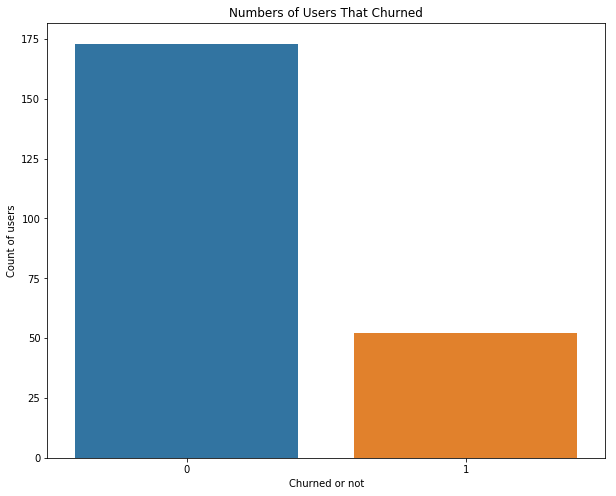

In [32]:
# plot the number of users that churned
plt.figure(figsize = [10,8])
sns.barplot(data = df_churned, x = 'churn', y='count')
plt.xlabel('Churned or not')
plt.ylabel('Count of users')
plt.title("Numbers of Users That Churned")
plt.show()

#### Artists (number unique):

In [33]:
# get pandas dataframe for number of unique artists per user, grouped by churn:
df_artist = df.filter(df.page == "NextSong").select(['userId','churn','artist'])\
    .dropDuplicates().groupby('userId','churn').count().toPandas()

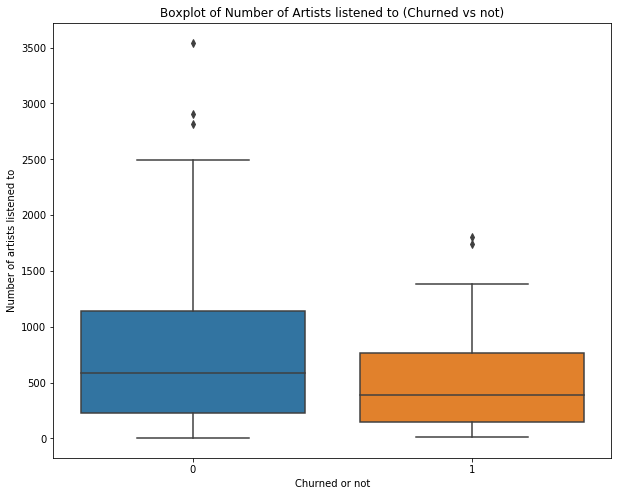

In [34]:
# plot the number of users that churned by number of unique artists listen to by user:
plt.figure(figsize = [10,8])
sns.boxplot(data = df_artist, x = 'churn', y='count')
plt.xlabel('Churned or not')
plt.ylabel('Number of artists listened to')
plt.title("Boxplot of Number of Artists listened to (Churned vs not)")
plt.show()

Those who didn't churn (O) listened to a larger number of artists (with a higher mean) than those who did churn (1)

#### Gender: 

In [35]:
# get pandas dataframe for unique customers split by gender
df_gender = df.select(['userId','churn','gender']).dropDuplicates().groupby('gender','churn').count().toPandas()

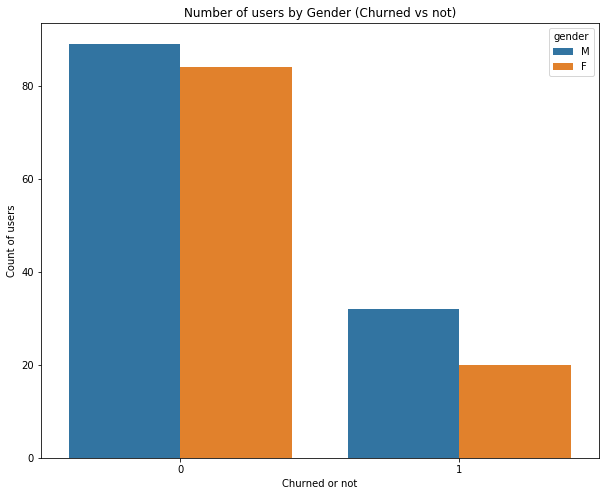

In [36]:
# plot the number of users that churned by gender:
plt.figure(figsize = [10,8])
sns.barplot(data = df_gender, x = 'churn', y='count', hue='gender')
plt.xlabel('Churned or not')
plt.ylabel('Count of users')
plt.title("Number of users by Gender (Churned vs not)")
plt.show()

In [37]:
df_gender

,gender,churn,count
0,M,1,32
1,F,0,84
2,F,1,20
3,M,0,89


From the plots above, more male users churned than female users, with 26% of males churning compared to 19% females

#### Length:

In [38]:
# Sort the dataframe by target
df_length = df.toPandas()
df_length.dropna(axis=0, subset=['length'], inplace=True)

no_churn = df_length[df_length['churn'] == 0]
churn = df_length[df_length['churn'] == 1]

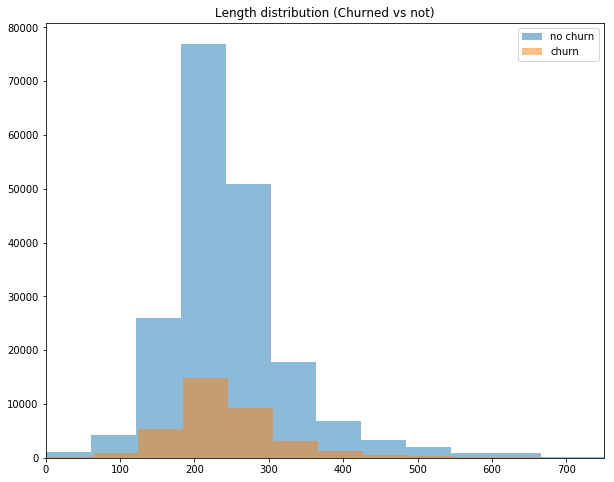

In [39]:
#Plot this
plt.figure(figsize = [10,8])
plt.hist(no_churn['length'], 
         alpha=0.5, # the transaparency parameter
         label='no churn', bins = 50 )
  
plt.hist(churn['length'],
         alpha=0.5,
         label='churn',  bins = 50)

plt.xlim(0,750)

plt.legend(loc='upper right')
plt.title('Length distribution (Churned vs not)')
plt.show()

# Reference: https://stackoverflow.com/questions/42014687/histogram-plotting-attributeerror-max-must-be-larger-than-min-in-range-paramet
# Referene: https://www.geeksforgeeks.org/overlapping-histograms-with-matplotlib-in-python/


Even though there is less that churned that did not, it is clear that the distributions are similar. So this will not be useful in predicting

#### Average Length of each session:

In [40]:
# Sort the dataframe by target
df_length_session = df.select(['userId','churn','sessionId','length'])\
    .groupby('userId','churn','sessionId').agg({'length':'sum'}).withColumnRenamed('sum(length)','session length')

df_length_session.show()
#https://www.learneasysteps.com/how-to-sum-by-group-in-pyspark/

+------+-----+---------+------------------+
|userId|churn|sessionId|    session length|
+------+-----+---------+------------------+
|100010|    0|       31| 6910.366360000001|
|100010|    0|       78|        1597.56743|
|100010|    0|      113| 9295.264389999998|
|100010|    0|      118|       10463.43147|
|100010|    0|      133|       13040.32954|
|100010|    0|      174|        19634.6674|
|100010|    0|      187| 5999.270759999999|
|200002|    0|        2|         838.71165|
|200002|    0|       44| 4875.406449999999|
|200002|    0|      114|        8266.56416|
|200002|    0|      163|28491.597589999994|
|200002|    0|      174| 22190.69133999999|
|200002|    0|      205|29345.904749999983|
|   125|    1|      174|2089.1131000000005|
|   124|    0|      123|       66182.41049|
|   124|    0|      333| 37281.94434999998|
|   124|    0|      420| 93733.06118999995|
|   124|    0|      511|        1388.09151|
|   124|    0|      517|       28714.23648|
|   124|    0|      628|        

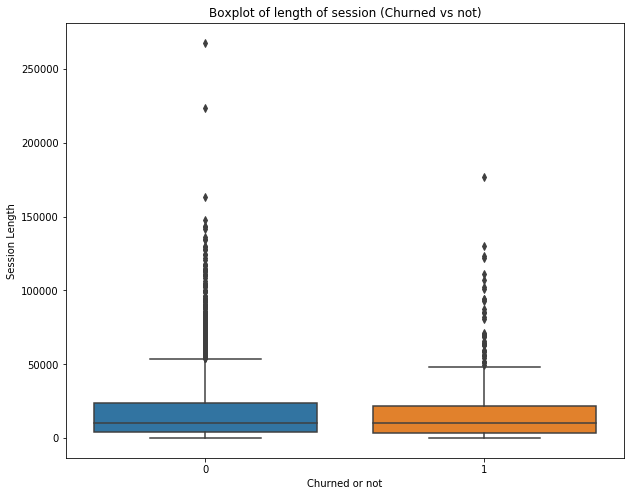

In [41]:
df_length_session_pd = df_length_session.toPandas()

plt.figure(figsize = [10,8])
sns.boxplot(data = df_length_session_pd, x = 'churn', y='session length')
plt.xlabel('Churned or not')
plt.ylabel('Session Length')
plt.title("Boxplot of length of session (Churned vs not)")
plt.show()

In [42]:
df_length_session_pd[df_length_session_pd['churn']==1].describe()

,churn,sessionId,session length
count,537.0,537.000000,519.000000
mean,1.0,503.249534,17434.955616
std,0.0,488.802723,21992.499265
min,1.0,1.000000,45.635460
25%,1.0,125.000000,3737.150020
50%,1.0,306.000000,9891.743050
75%,1.0,784.000000,21830.293680
max,1.0,2003.000000,176615.411270


In [43]:
df_length_session_pd[df_length_session_pd['churn']==0].describe()

,churn,sessionId,session length
count,2639.0,2639.000000,2552.000000
mean,0.0,1007.759379,18721.348034
std,0.0,742.759458,23522.788066
min,0.0,1.000000,141.844440
25%,0.0,311.000000,4037.752072
50%,0.0,895.000000,10391.399280
75%,0.0,1672.500000,23861.768823
max,0.0,2474.000000,267758.132910


#### Level:

In [44]:
# get pandas dataframe for unique customers split by level
df_level = df.select(['userId','churn','level']).dropDuplicates().groupby('level','churn').count().toPandas()

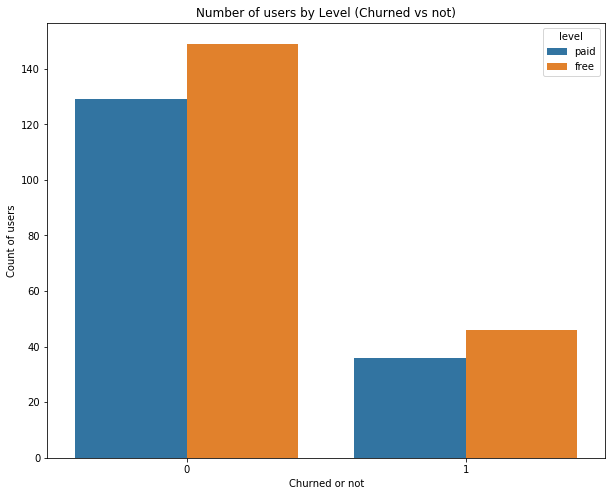

In [45]:
# plot the number of users that churned by level:
plt.figure(figsize = [10,8])
sns.barplot(data = df_level, x = 'churn', y='count', hue='level')
plt.xlabel('Churned or not')
plt.ylabel('Count of users')
plt.title("Number of users by Level (Churned vs not)")
plt.show()

In [46]:
df_level

,level,churn,count
0,paid,0,129
1,free,0,149
2,paid,1,36
3,free,1,46


Slightly more of those who use it for free churn than those who do not, with 24% free users churning compared to 22% paid (not unique though)

In [47]:
#partition (explanation for this is below in the Registration/TS section)

window_ts = Window.partitionBy("userId").orderBy(desc('ts'),desc('itemInSession'))
df_level_unique = df.withColumn("rank", rank().over(window_ts)) 

df_level_unique = df_level_unique[df_level_unique['rank']==1]

In [48]:
df_level_unique = df_level_unique.groupby('level','churn').count().toPandas()

In [49]:
df_level_unique.count()

level    4
churn    4
count    4
dtype: int64

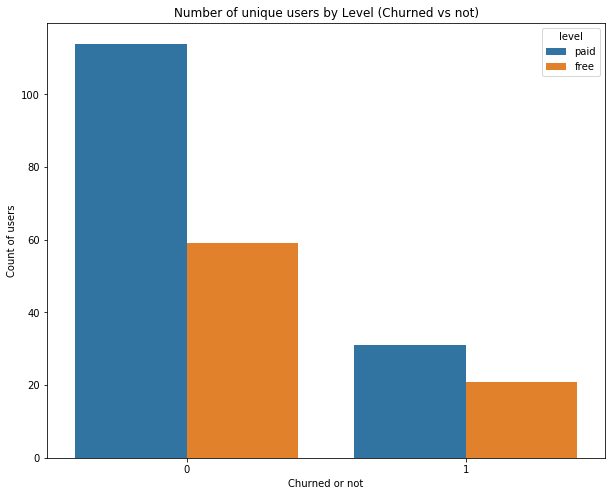

In [50]:
# plot the number of users that churned by level:
plt.figure(figsize = [10,8])
sns.barplot(data = df_level_unique, x = 'churn', y='count', hue='level')
plt.xlabel('Churned or not')
plt.ylabel('Count of users')
plt.title("Number of unique users by Level (Churned vs not)")
plt.show()

In [51]:
df_level_unique

,level,churn,count
0,paid,0,114
1,free,0,59
2,paid,1,31
3,free,1,21


#### Location:

In [52]:
#split the strings
split_col = split(df['location'], ',')
df = df.withColumn('Place', split_col.getItem(0))
df = df.withColumn('Letters', split_col.getItem(1))

#https://www.datasciencemadesimple.com/string-split-of-the-columns-in-pyspark/
#https://stackoverflow.com/questions/39235704/split-spark-dataframe-string-column-into-multiple-columns

In [53]:
df_place = df.select('Place','userId','churn').dropDuplicates().groupby('Place','churn').count().toPandas()

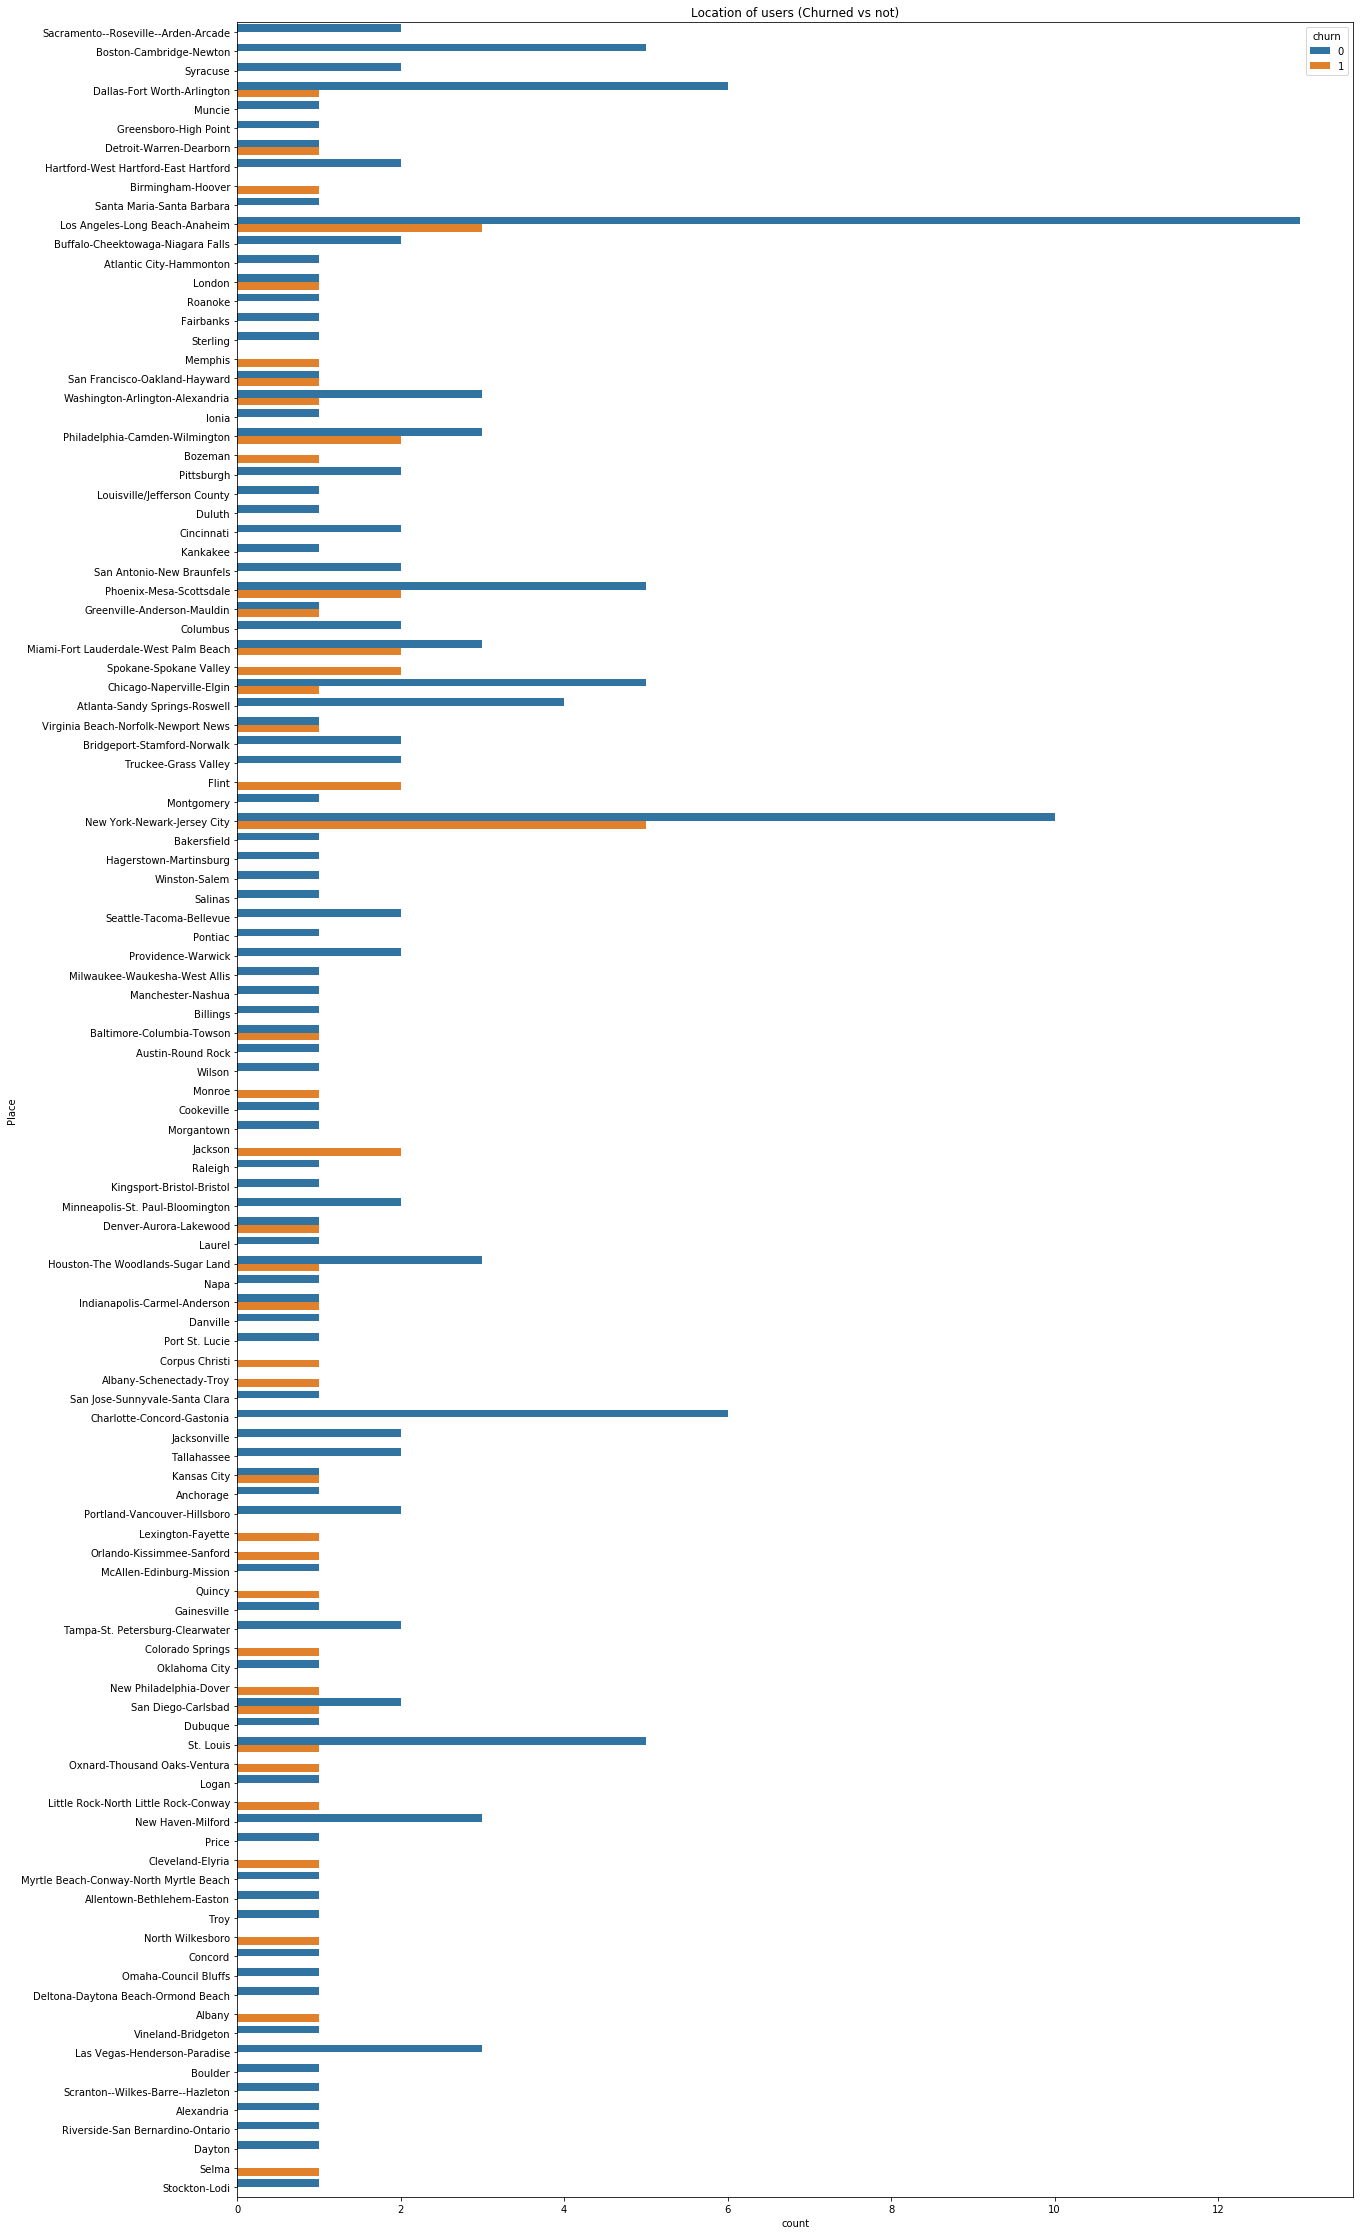

In [54]:
plt.figure(figsize=[20,40])
sns.barplot(data = df_place, x = 'count', y = 'Place', hue = 'churn')
plt.title('Location of users (Churned vs not)');

In [55]:
df.toPandas()['Letters'].unique()

array([' CT', ' IL-IN-WI', ' TX', ' NJ', ' KY', ' WA', ' WV', ' MA-NH',
       ' NY-NJ-PA', ' CO', ' RI-MA', ' MI', ' CA', ' WI', ' IN', ' VA',
       ' NY', ' IL-MO', ' UT-ID', ' MT', ' NC-SC', ' FL', ' SC-NC',
       ' MO-IL', ' OH-KY-IN', ' OH', ' NC', ' DC-VA-MD-WV', ' GA', ' TN',
       ' GA-AL', ' IL', ' AZ', ' MO-KS', ' MS', ' LA', ' TN-VA', ' KY-IN',
       ' PA-NJ-DE-MD', ' AR', ' OK', ' MD-WV', ' AK', ' NH', ' NV',
       ' PA-NJ', ' SC', ' PA', ' AL', ' TN-MS-AR', ' OR', ' MD', ' OR-WA',
       ' UT', ' VA-NC', ' MN-WI', ' NE-IA', ' IA'], dtype=object)

In [56]:
df.toPandas()['Letters'].nunique()

58

There does seem to be a difference, however due to the high amount of locations and small sample of users this is unlikely to be helpful so I will leave this for now. Also some people's location have multiple states so is hard to split up further. Eg: TN-MS-AR is from Arkansas, Tennessee, Mississippi

Reference: https://censusreporter.org/profiles/31000US32820-memphis-tn-ms-ar-metro-area/

#### Pages visited:

In [57]:
# get pandas dataframe for unique customers split by page
df_pages_unique = df.select(['userId','churn','page']).dropDuplicates().groupby('page','churn').count().toPandas()
df_pages_full = df.select(['userId','churn','page']).groupby('page','churn').count().toPandas()

In [58]:
df_pages_unique

,page,churn,count
0,Thumbs Up,0,170
1,Upgrade,0,131
2,Logout,0,167
3,Upgrade,1,37
4,Add Friend,1,44
5,Error,1,22
6,Home,1,51
7,NextSong,0,173
8,Submit Upgrade,0,102
9,Help,0,149


In [59]:
## Look at percentages:
df_full_pages = ((df_pages_full.groupby(['page','churn']).sum()/df_pages_full.groupby(['churn']).sum())*100).reset_index()

# Referencce: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
df_full_pages

,page,churn,count
0,About,0,0.188178
1,About,1,0.124822
2,Add Friend,0,1.560718
3,Add Friend,1,1.417618
4,Add to Playlist,0,2.352437
5,Add to Playlist,1,2.313659
6,Cancel,1,0.115906
7,Cancellation Confirmation,1,0.115906
8,Downgrade,0,0.736422
9,Downgrade,1,0.751159


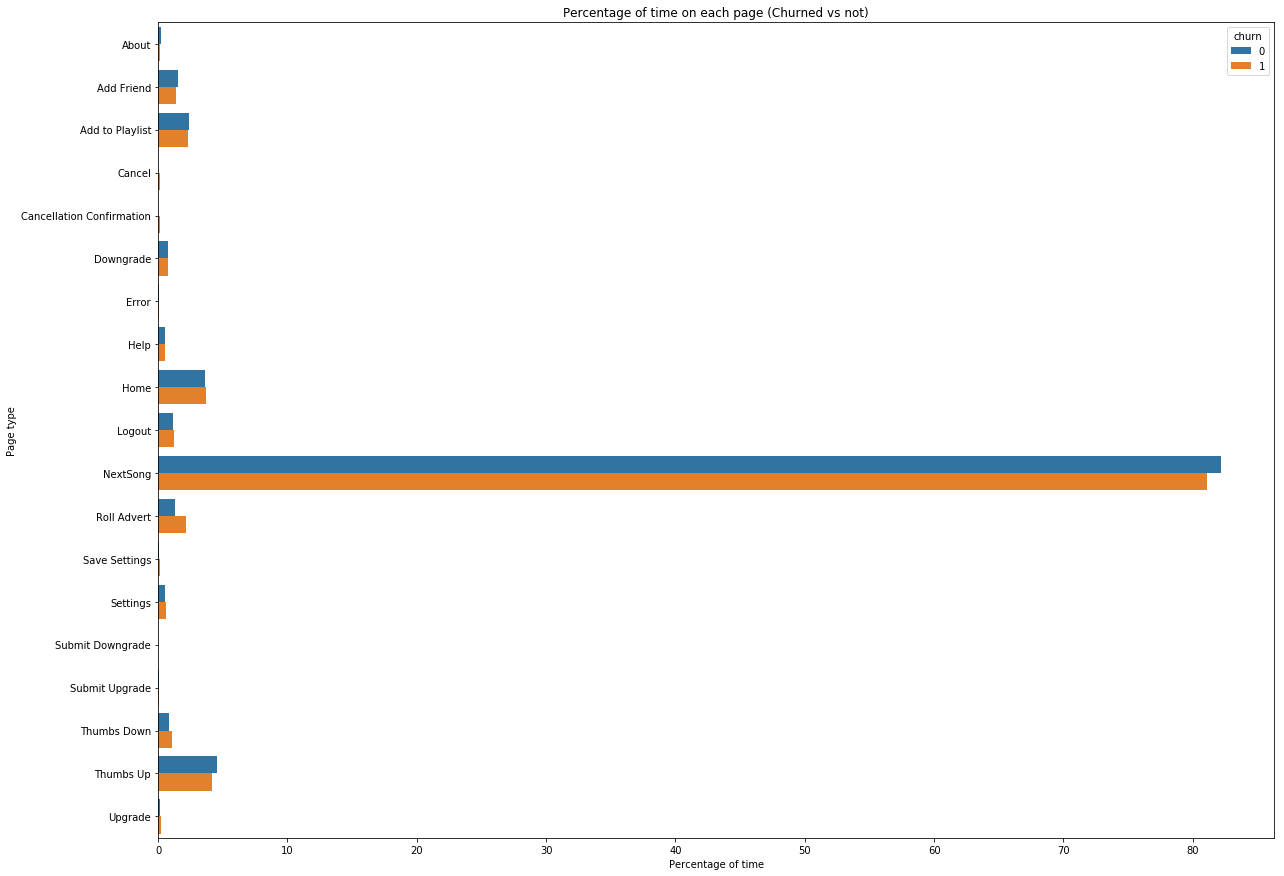

In [60]:
plt.figure(figsize = [20,15])
sns.barplot(data = df_full_pages, x = 'count', y='page', hue='churn')
plt.xlabel('Percentage of time')
plt.ylabel('Page type')
plt.title("Percentage of time on each page (Churned vs not)")
plt.show()

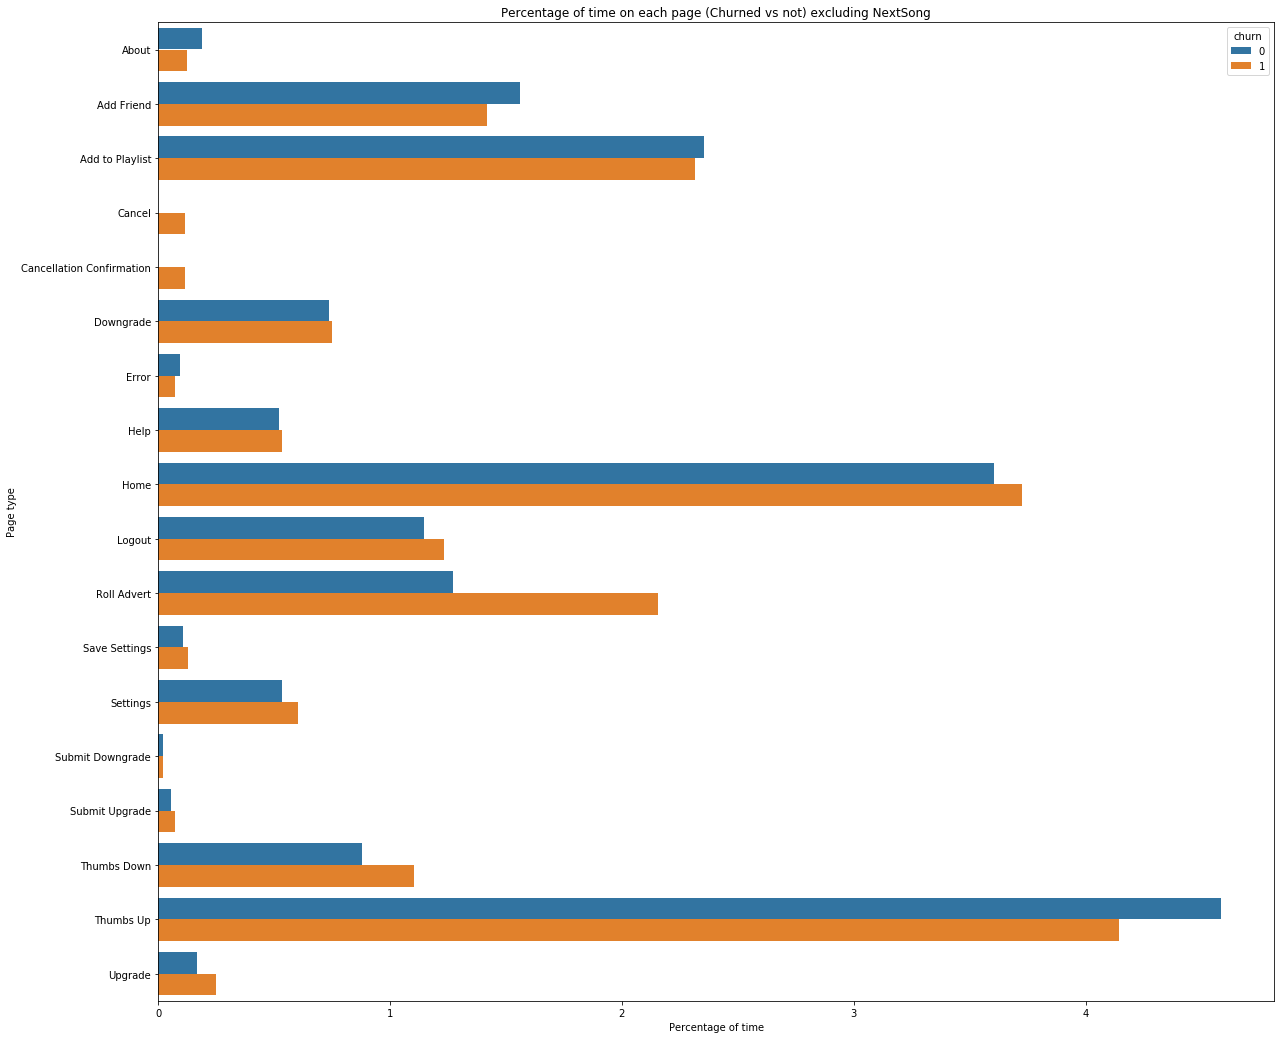

In [61]:
plt.figure(figsize = [20,18])
sns.barplot(data = df_full_pages[df_full_pages['page']!= 'NextSong'], x = 'count', y='page', hue='churn')
plt.xlabel('Percentage of time')
plt.ylabel('Page type')
plt.title("Percentage of time on each page (Churned vs not) excluding NextSong")
plt.show()

#### Registration/Timestamp (how long they have been registered for):

In [62]:
df_time = df.select(['userId','churn','registration','ts']).dropDuplicates().toPandas()

In [63]:
df_time.head(5)

,userId,churn,registration,ts
0,100010,0,1538016340000,1539003534000
1,100010,0,1538016340000,1539003736000
2,100010,0,1538016340000,1539003932000
3,100010,0,1538016340000,1539003933000
4,100010,0,1538016340000,1539004195000


In [64]:
#For each user ID get last time stamp (most recent action):
window_ts = Window.partitionBy("userId").orderBy(desc('ts'))

In [65]:
df_time = df.withColumn("rank", rank().over(window_ts)) 
df_time.show(3)
#https://www.geeksforgeeks.org/pyspark-window-functions/

+----------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+-----------+------+-------------+--------------------+------+-----+---------+----------------------+--------------------+-------+----+
|    artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|       song|status|           ts|           userAgent|userId|churn|downgrade|downgrade_or_cancelled|               Place|Letters|rank|
+----------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+-----------+------+-------------+--------------------+------+-----+---------+----------------------+--------------------+-------+----+
|      null|Logged In| Darianna|     F|           34|Carpenter|     null| free|Bridgeport-Stamfo...|   PUT|  Logout|1538016340000|      187|       null|   307|1542823952000|"M

In [66]:
df_filtered = df_time[df_time['rank']==1].toPandas()
df_filtered.count()

artist                    46 
auth                      227
firstName                 227
gender                    227
itemInSession             227
lastName                  227
length                    46 
level                     227
location                  227
method                    227
page                      227
registration              227
sessionId                 227
song                      46 
status                    227
ts                        227
userAgent                 227
userId                    227
churn                     227
downgrade                 227
downgrade_or_cancelled    227
Place                     227
Letters                   227
rank                      227
dtype: int64

In [67]:
df_filtered[df_filtered['userId'].isin(df_filtered['userId'].value_counts().loc[lambda x: x>1].index)]

# Reference: https://re-thought.com/pandas-value_counts/

# Can see that iteminSession is different so also need to order by that

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,status,ts,userAgent,userId,churn,downgrade,downgrade_or_cancelled,Place,Letters,rank
2,None,Logged In,Mason,M,9,Hart,NaN,free,"Corpus Christi, TX",PUT,...,307,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",125,1,0,1,Corpus Christi,TX,1
3,None,Cancelled,Mason,M,10,Hart,NaN,free,"Corpus Christi, TX",GET,...,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",125,1,0,1,Corpus Christi,TX,1
176,Rosie Vela,Logged In,Aurora,F,118,Humphrey,254.77179,paid,"Dallas-Fort Worth-Arlington, TX",PUT,...,200,1543351229000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",127,0,1,1,Dallas-Fort Worth-Arlington,TX,1
177,None,Logged In,Aurora,F,119,Humphrey,NaN,paid,"Dallas-Fort Worth-Arlington, TX",GET,...,200,1543351229000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",127,0,1,1,Dallas-Fort Worth-Arlington,TX,1


In [68]:
#For each user ID get last time stamp (most recent action):
window_ts = Window.partitionBy("userId").orderBy(desc('ts'),desc('itemInSession'))
df_time = df.withColumn("rank", rank().over(window_ts)) 

df_time[df_time['rank']==1].count()
# Reference: https://www.educba.com/pyspark-orderby-descending/

225

In [69]:
df_time=df_time[df_time['rank']==1]

In [70]:
df_time.show(5)

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+---------+----------------------+--------------------+---------+----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|downgrade|downgrade_or_cancelled|               Place|  Letters|rank|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+---------+----------------------+--------------------+---------+----+
|  null|Logged In| Darianna|     F|           34|Carpenter|  null| free|Bridgeport-Stamfo...|   PUT|              Logout|1538016340000|      187|null|   307|1542823952000|"Moz

In [71]:
# Now want tof find difference between ts and registration

sec_converter =  udf(lambda x: x/1000/60, FloatType())
min_converter =  udf(lambda x: x/1000/60, FloatType())
hour_converter =  udf(lambda x: x/1000/60/60, FloatType())
day_converter = udf(lambda x: x/1000/60/60/24, FloatType())

df_time = df_time.withColumn('day_diff', day_converter((df_time['ts']) - (df_time['registration'])))


# Reference: https://stackoverflow.com/questions/45603232/python-difference-between-two-unix-timestamps
# https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/

In [72]:
df_time_pd = df_time.toPandas()

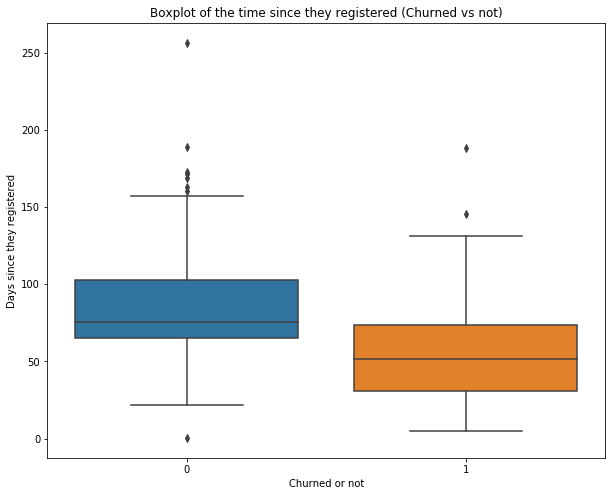

In [73]:
plt.figure(figsize = [10,8])
sns.boxplot(data = df_time_pd, x = 'churn', y='day_diff')
plt.xlabel('Churned or not')
plt.ylabel('Days since they registered')
plt.title("Boxplot of the time since they registered (Churned vs not)")
plt.show()

#### Sessions (number had):

In [74]:
df_sessions_per_user = df.select(['userId','churn','sessionId']).dropDuplicates().groupby('userId','churn').count().toPandas()

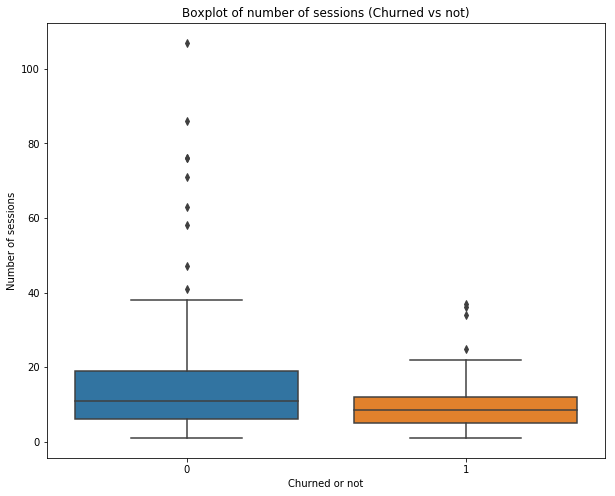

In [75]:
plt.figure(figsize = [10,8])
sns.boxplot(data = df_sessions_per_user, x = 'churn', y='count')
plt.xlabel('Churned or not')
plt.ylabel('Number of sessions')
plt.title("Boxplot of number of sessions (Churned vs not)")
plt.show()

In [76]:
df_sessions_per_user[df_sessions_per_user['churn']==1].describe()

,churn,count
count,52.0,52.000000
mean,1.0,10.326923
std,0.0,8.610803
min,1.0,1.000000
25%,1.0,5.000000
50%,1.0,8.500000
75%,1.0,12.000000
max,1.0,37.000000


In [77]:
df_sessions_per_user[df_sessions_per_user['churn']==0].describe()

,churn,count
count,173.0,173.000000
mean,0.0,15.254335
std,0.0,15.866963
min,0.0,1.000000
25%,0.0,6.000000
50%,0.0,11.000000
75%,0.0,19.000000
max,0.0,107.000000


#### Number songs played:

In [78]:
df_songs = df.select(['userId','churn','song']).where(df.page == 'NextSong').groupby('userId','churn').count().toPandas()
#could also look for the number of times there was page Next song as these equals the number of songs

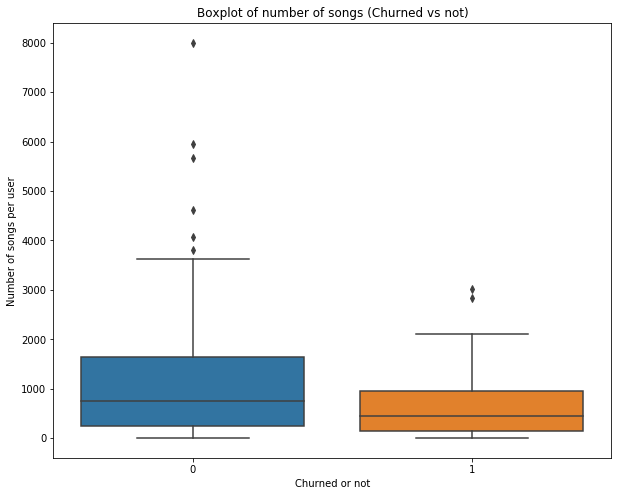

In [79]:
plt.figure(figsize = [10,8])
sns.boxplot(data = df_songs, x = 'churn', y='count')
plt.xlabel('Churned or not')
plt.ylabel('Number of songs per user')
plt.title("Boxplot of number of songs (Churned vs not)")
plt.show()

In [80]:
df_songs[df_songs['churn']==1].describe()

,churn,count
count,52.0,52.000000
mean,1.0,699.884615
std,0.0,714.737650
min,1.0,8.000000
25%,1.0,148.750000
50%,1.0,452.500000
75%,1.0,963.500000
max,1.0,3028.000000


In [81]:
df_songs[df_songs['churn']==0].describe()

,churn,count
count,173.0,173.000000
mean,0.0,1108.173410
std,0.0,1183.146703
min,0.0,3.000000
25%,0.0,251.000000
50%,0.0,747.000000
75%,0.0,1640.000000
max,0.0,8002.000000


#### Songs (number unique):

In [82]:
df_songs_unique = df.select(['userId','churn','song']).where(df.page == 'NextSong').dropDuplicates().groupby('userId','churn').count().toPandas()

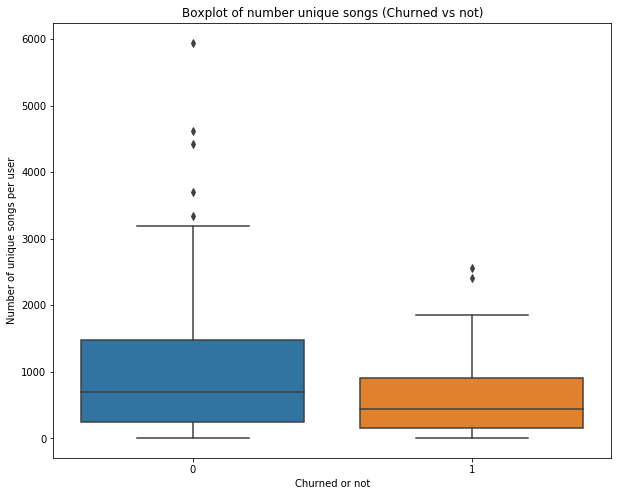

In [83]:
plt.figure(figsize = [10,8])
sns.boxplot(data = df_songs_unique, x = 'churn', y='count')
plt.xlabel('Churned or not')
plt.ylabel('Number of unique songs per user')
plt.title("Boxplot of number unique songs (Churned vs not)")
plt.show()

In [84]:
df_songs_unique[df_songs_unique['churn']==1].describe()

,churn,count
count,52.0,52.000000
mean,1.0,638.365385
std,0.0,619.598669
min,1.0,8.000000
25%,1.0,147.000000
50%,1.0,432.500000
75%,1.0,901.500000
max,1.0,2562.000000


In [85]:
df_songs_unique[df_songs_unique['churn']==0].describe()

,churn,count
count,173.0,173.000000
mean,0.0,975.768786
std,0.0,951.912881
min,0.0,3.000000
25%,0.0,239.000000
50%,0.0,696.000000
75%,0.0,1477.000000
max,0.0,5946.000000


#### User Agent:

In [86]:
df.select('userAgent').dropDuplicates().toPandas()

,userAgent
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"""
1,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"""
2,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"""
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"""
5,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0
6,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0
7,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0
8,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)
9,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"""


In [87]:
# there is only a few different types: Windows, Macintosh, iPhone, 'X11;Linux', 

In [88]:
df = df.withColumn("operating_system", when(df.userAgent.contains('Windows') ,"Windows")
                                 .when(df.userAgent.contains('iPhone') ,"phone/tablet")
                                 .when(df.userAgent.contains('X11') ,"X11")
                                 .when(df.userAgent.contains('iPad') ,"phone/tablet")
                                 .when(df.userAgent.contains('Macintosh') ,"Macintosh"))

#https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/

In [89]:
df.select('userAgent','operating_system').dropDuplicates().toPandas()

,userAgent,operating_system
0,Mozilla/5.0 (Windows NT 6.1; rv:31.0) Gecko/20100101 Firefox/31.0,Windows
1,"""Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D201 Safari/9537.53""",phone/tablet
2,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",Windows
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",Macintosh
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",Macintosh
5,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",Macintosh
6,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0,X11
7,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0,Windows
8,Mozilla/5.0 (X11; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0,X11
9,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0,X11


In [90]:
df_operating = df.select(['userId','churn','operating_system']).dropDuplicates()\
    .groupby('operating_system','churn').count().toPandas()

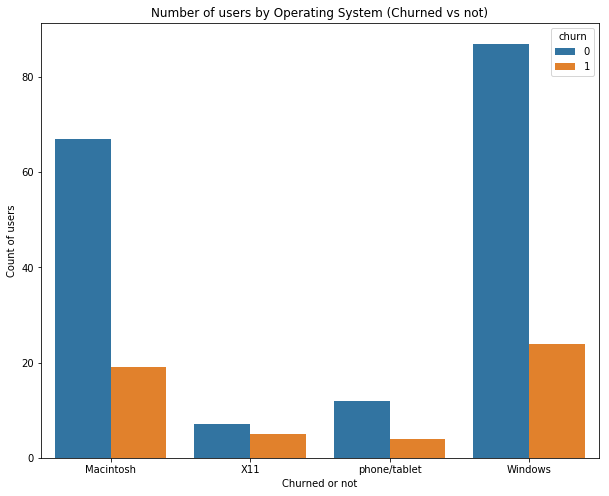

In [91]:
plt.figure(figsize = [10,8])
sns.barplot(data = df_operating , x = 'operating_system', y='count', hue='churn')
plt.xlabel('Churned or not')
plt.ylabel('Count of users')
plt.title("Number of users by Operating System (Churned vs not)")
plt.show()

In [92]:
df_operating

,operating_system,churn,count
0,Macintosh,0,67
1,X11,0,7
2,X11,1,5
3,phone/tablet,0,12
4,phone/tablet,1,4
5,Macintosh,1,19
6,Windows,0,87
7,Windows,1,24


It looks like there is a difference, with many X11 Linux users churning, but this is a very low sample size.

#### Downgraded or not:

In [93]:
df_downgraded = df.select(['userId','churn','downgrade']).dropDuplicates().groupby('downgrade','churn').count().toPandas()

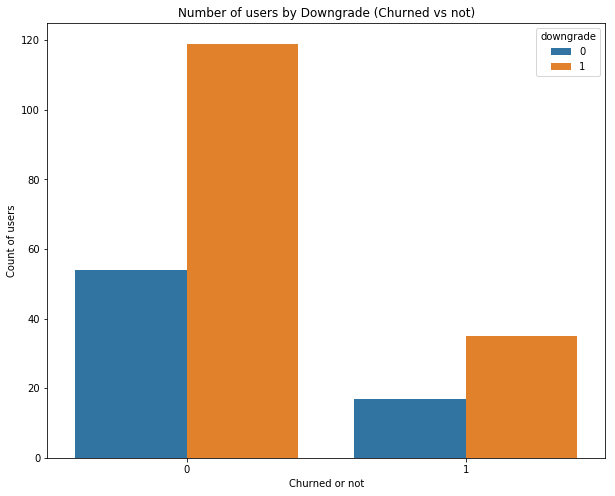

In [94]:
plt.figure(figsize = [10,8])
sns.barplot(data = df_downgraded, x = 'churn', y='count', hue='downgrade')
plt.xlabel('Churned or not')
plt.ylabel('Count of users')
plt.title("Number of users by Downgrade (Churned vs not)")
plt.show()

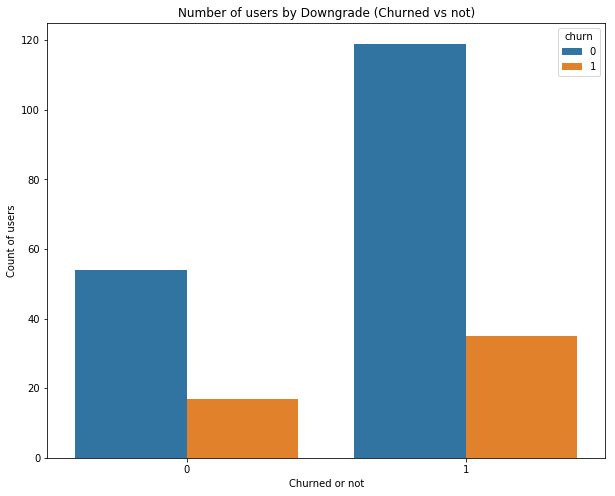

In [95]:
plt.figure(figsize = [10,8])
sns.barplot(data = df_downgraded, x = 'downgrade', y='count', hue='churn')
plt.xlabel('Churned or not')
plt.ylabel('Count of users')
plt.title("Number of users by Downgrade (Churned vs not)")
plt.show()

In [96]:
df_downgraded

,downgrade,churn,count
0,1,0,119
1,1,1,35
2,0,0,54
3,0,1,17


# Feature Engineering
Now I have familiarized myself with the data, I am going to build out the features that looked promising from the EDA. 

These are:
1. Number of unique artists listened to (numerical)
2. Gender (categorical)
3. Level (categorical)
4. Roll Advert number (numerical)
5. Thumbs Down number (numerical)
6. Thumbs Up number (numerical)
7. Add Friend count (numerical)
8. Time registered in days (numerical)
9. Number of sessions
10. Number of songs played
11. Number of unique songs played
12. Churned or not 


In [97]:
# Reload the initial data set to make sure all preprocessing steps are visible in this section:

In [98]:
# Load the dataset:
df = spark.read.json("mini_sparkify_event_data.json")

# Remove empty columns:
df = df.filter(df["userId"] != "")

In [99]:
#Get dataframe of unique customers:

#For each user ID get last time stamp (most recent action):
window = Window.partitionBy("userId").orderBy(desc('ts'),desc('itemInSession'))
df_unique = df.withColumn("rank", rank().over(window_ts)) 

df_unique = df_unique[df_unique['rank']==1]
df_unique.count()

225

#### Feature 1: Number of unique artists listened to (`numArtists`):


In [100]:
feat1_df = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "numArtists")

In [101]:
feat1_df.count()

225

In [102]:
feat1_df.toPandas().head(2)

,userId,numArtists
0,100010,252
1,200002,339


#### Feature 2: Gender (`isFemale`):

In [103]:
#Need to make this categorical feature binary
feat2_df = df_unique.select(['userId','gender'])\
    .withColumn('isFemale', when(df.gender == 'F', 1).otherwise(0))\
    .drop('gender')
#https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/

In [104]:
feat2_df.count()

225

In [105]:
feat2_df.toPandas().head(2)

,userId,isFemale
0,100010,1
1,200002,0


In [106]:
feat2_df.toPandas()['isFemale'].value_counts()

0    121
1    104
Name: isFemale, dtype: int64

#### Feature 3 : Level (`isPaid`):

In [107]:
#Need to make this categorical feature binary
feat3_df = df_unique.select(['userId','level'])\
    .withColumn('isPaid', when(df.level == 'paid', 1).otherwise(0))\
    .drop('level')

In [108]:
feat3_df.count()

225

In [109]:
feat3_df.toPandas().head(2)

,userId,isPaid
0,100010,0
1,200002,1


In [110]:
feat3_df.toPandas()['isPaid'].value_counts()

1    145
0    80 
Name: isPaid, dtype: int64

#### Page Features:

In [111]:
#Creating a function to make this easier:

def page_counts(df, col_name, output_name):
    ''' This function takes the page name and outputs, for each user, how many times they visited it
    
    Input: df, page name, name of output column
    Output: dataframe containing a row for each user, showing how many times they visited a page
    
    '''
    df_output = df.select('userId','page')\
                  .where(df.page == col_name).groupBy('userId').count()\
                  .withColumnRenamed('count', output_name)
    print('DataFrame Count: ' + str(df_output.count()))
    print('Head of data:')
    print(df_output.toPandas().head(2))
    return df_output

#Note: the df won't always be 225 for count( as not all users will have visited each page). This is fine
# as I will left join later, and fill nulls with 0's. However, I will which to see if the counts 
# match page count from earlier in my analysis

#### Feature 4: Roll Advert Number (`advertCount`):

In [112]:
feat4_df = page_counts(df, 'Roll Advert', 'advertCount')

DataFrame Count: 207
Head of data:
   userId  advertCount
0  100010  52         
1  200002  7          


In [113]:
feat4_df.show(5)

+------+-----------+
|userId|advertCount|
+------+-----------+
|100010|         52|
|200002|          7|
|   125|          1|
|     7|         16|
|   124|          4|
+------+-----------+
only showing top 5 rows



#### Feature 5: Thumbs Down Number (`thumbsDownCount`):

In [114]:
feat5_df = page_counts(df, 'Thumbs Down', 'thumbsDownCount')

DataFrame Count: 203
Head of data:
   userId  thumbsDownCount
0  100010  5              
1  200002  6              


In [115]:
feat5_df.show(5)

+------+---------------+
|userId|thumbsDownCount|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
+------+---------------+
only showing top 5 rows



#### Feature 6: Thumbs Down Number (`thumbsUpCount`):

In [116]:
feat6_df = page_counts(df, 'Thumbs Up', 'thumbsUpCount')

DataFrame Count: 220
Head of data:
   userId  thumbsUpCount
0  100010  17           
1  200002  21           


In [117]:
feat6_df.show(5)

+------+-------------+
|userId|thumbsUpCount|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
+------+-------------+
only showing top 5 rows



#### Feature 7: Number of Friends added (`addFriendCount`):

In [118]:
feat7_df = page_counts(df, 'Add Friend', 'addFriendCount')

DataFrame Count: 206
Head of data:
   userId  addFriendCount
0  100010  4             
1  200002  4             


In [119]:
feat7_df.show(5)

+------+--------------+
|userId|addFriendCount|
+------+--------------+
|100010|             4|
|200002|             4|
|    51|            28|
|   124|            74|
|     7|             1|
+------+--------------+
only showing top 5 rows



#### Feature 8: Time Since Registering (`daysRegistered`):

In [120]:
feat8_df = df_unique.withColumn('daysRegistered', (df_unique.ts - df_unique.registration)/1000/60/60/24)\
    .select('userId','daysRegistered')

In [121]:
feat8_df.count()

225

In [122]:
feat8_df.toPandas().head(2)

,userId,daysRegistered
0,100010,55.643657
1,200002,70.074630


#### Feature 9: Number of sessions (`numSessions`):

In [123]:
feat9_df= df.select(['userId','sessionId']).dropDuplicates().groupby('userId').count()\
    .withColumnRenamed("count","numSessions")

In [124]:
feat9_df.count()

225

In [125]:
feat9_df.toPandas().head(2)

,userId,numSessions
0,100010,7
1,200002,6


#### Feature 10: Number of songs (`numSongs`):

In [126]:
feat10_df= df.select(['userId','song']).where(df.page == 'NextSong').groupby('userId').count()\
    .withColumnRenamed("count","numSongs")

In [127]:
feat10_df.count()

225

In [128]:
feat10_df.toPandas().head(2)

,userId,numSongs
0,100010,275
1,200002,387


#### Feature 11: Number of unique songs (`numSongsUnique`):

In [129]:
feat11_df= df.select(['userId','song']).where(df.page == 'NextSong').dropDuplicates().groupby('userId').count()\
    .withColumnRenamed("count","numSongsUnique")

In [130]:
feat11_df.count()

225

In [131]:
feat11_df.toPandas().head(2)

,userId,numSongsUnique
0,100010,269
1,200002,378


#### Target Variable: Churn (`label`):

In [132]:
churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
target_df= df.withColumn("churn",churn("page"))
target_df = target_df.withColumn("churn", max('churn').over(window)).select('userId','churn')\
    .withColumnRenamed("churn","label").dropDuplicates()


In [133]:
target_df.count()

225

In [134]:
target_df.toPandas()['label'].value_counts()

0    173
1    52 
Name: label, dtype: int64

#### Combine all features:

In [135]:
feature_data = target_df.join(feat1_df, 'userId', 'left')\
                        .join(feat2_df, 'userId', 'left')\
                        .join(feat3_df, 'userId', 'left')\
                        .join(feat4_df, 'userId', 'left')\
                        .join(feat5_df, 'userId', 'left')\
                        .join(feat6_df, 'userId', 'left')\
                        .join(feat7_df, 'userId', 'left')\
                        .join(feat8_df, 'userId', 'left')\
                        .join(feat9_df, 'userId', 'left')\
                        .join(feat10_df, 'userId', 'left')\
                        .join(feat11_df, 'userId', 'left')\
                        .fillna(0)\
                        .drop('userId')

# https://sparkbyexamples.com/pyspark/pyspark-fillna-fill-replace-null-values/

In [136]:
feature_data.count()

225

In [137]:
feature_data.toPandas().head(15)

,label,numArtists,isFemale,isPaid,advertCount,thumbsDownCount,thumbsUpCount,addFriendCount,daysRegistered,numSessions,numSongs,numSongsUnique
0,0,252,1,0,52,5,17,4,55.643657,7,275,269
1,0,339,0,1,7,6,21,4,70.074630,6,387,378
2,1,8,0,0,1,0,0,0,71.316887,1,8,8
3,0,2232,1,1,4,41,171,74,131.555914,29,4079,3339
4,1,1385,0,1,0,21,100,28,19.455845,10,2111,1854
5,0,142,0,0,16,1,7,1,72.778183,7,150,148
6,0,1302,0,1,1,14,81,31,56.513576,15,1914,1707
7,1,1744,1,1,47,29,163,33,110.751690,37,2841,2414
8,0,643,1,1,8,3,58,11,23.556019,6,820,759
9,1,233,0,1,2,3,17,6,85.083403,6,257,248


#### Check if any features should be removed:

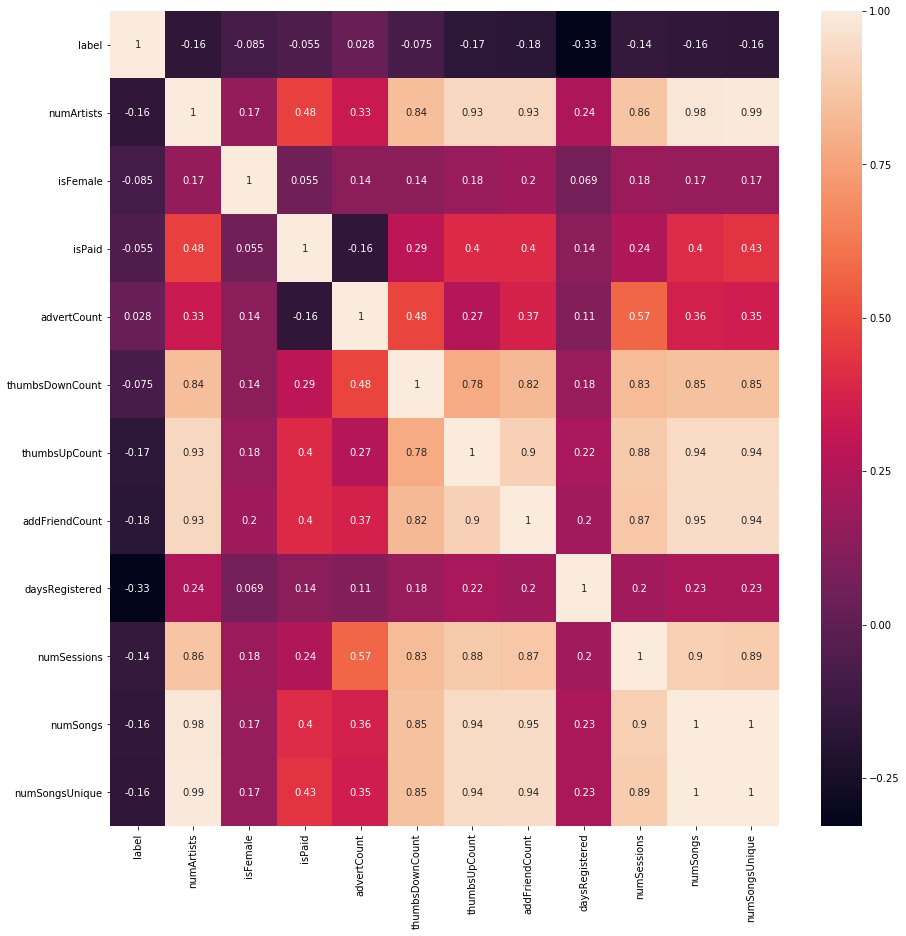

In [138]:
plt.figure(figsize = [15,15])
df_corr = feature_data.toPandas().corr()
sns.heatmap(df_corr, annot=True)
plt.show()

As expected, numSongs and numSongsUnique are have correlation of 1, so I will remove numSongsUnique as it is redundant. 
Many other variables have strong correlation (with correlation as high  as 0.98 between numArtists and numSongs and 0.95 between numSongs and addFriendCount). I will leave these in for now, but may want to consider removing them (curse of dimensionality)

https://datascience.stackexchange.com/questions/36404/when-to-remove-correlated-variables

In [139]:
feature_data = feature_data.drop('numSongsUnique')

In [140]:
feature_data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- numArtists: long (nullable = true)
 |-- isFemale: integer (nullable = true)
 |-- isPaid: integer (nullable = true)
 |-- advertCount: long (nullable = true)
 |-- thumbsDownCount: long (nullable = true)
 |-- thumbsUpCount: long (nullable = true)
 |-- addFriendCount: long (nullable = true)
 |-- daysRegistered: double (nullable = false)
 |-- numSessions: long (nullable = true)
 |-- numSongs: long (nullable = true)



In [141]:
#Now need to make sure that the features are in the correct (numerical) format:

for x, t in feature_data.dtypes:
    if t != 'int':
        feature_data = feature_data.withColumn(x, feature_data[x].cast('float'))

#https://stackoverflow.com/questions/49784063/spark-data-frames-check-if-column-is-of-type-integer
#https://www.geeksforgeeks.org/how-to-change-column-type-in-pyspark-dataframe/

In [142]:
#removing other high correlated variables:
feature_data_reduced = feature_data.drop('numSongs','numArtists')

# Modelling Preprocessing
I will go through the modelling steps now, starting by using VectorAssembler and StandardScaler. Then I will split the full dataset train, test, and validation sets. I will the evaluate different models. 

I will be using accuracy and F1 score (as there is an unbalanced dataset)

### Vector Assembler

Before we use the Scalers, I need to use Vector Assembler. This is because the other ML functions all require us to convert numeric to spark vector type

In [143]:
#Get the names of the features (minus the label column)
input_columns = feature_data.columns
input_columns.remove('label')

In [144]:
assembler = VectorAssembler(inputCols=input_columns , outputCol="features_vec")
feat_df = assembler.transform(feature_data)

### Standard Scaler

Now need to scale the features:

In [145]:
scaler = StandardScaler(inputCol = 'features_vec', outputCol = 'features')
scalerModel = scaler.fit(feat_df)
feat_df = scalerModel.transform(feat_df)

In [146]:
feat_df.toPandas().head(5)

,label,numArtists,isFemale,isPaid,advertCount,thumbsDownCount,thumbsUpCount,addFriendCount,daysRegistered,numSessions,numSongs,features_vec,features
0,0,252.0,1,0,52.0,5.0,17.0,4.0,55.643658,7.0,275.0,"[252.0, 1.0, 0.0, 52.0, 5.0, 17.0, 4.0, 55.6436576843, 7.0, 275.0]","[0.41725179203, 2.00127105192, 0.0, 2.41296984376, 0.382336621555, 0.259629487365, 0.194347247743, 1.47746907744, 0.477917329444, 0.248877612072]"
1,0,339.0,0,1,7.0,6.0,21.0,4.0,70.074631,6.0,387.0,"[339.0, 0.0, 1.0, 7.0, 6.0, 21.0, 4.0, 70.0746307373, 6.0, 387.0]","[0.561303005945, 0.0, 2.08442500134, 0.324822863583, 0.458803945866, 0.32071877851, 0.194347247743, 1.86064511817, 0.409643425238, 0.350238675898]"
2,1,8.0,0,0,1.0,0.0,0.0,0.0,71.316887,1.0,8.0,"(8.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 71.3168869019, 1.0, 8.0)","(0.0132460886359, 0.0, 0.0, 0.0464032662261, 0.0, 0.0, 0.0, 1.89362992086, 0.0682739042063, 0.00724007598756)"
3,0,2232.0,1,1,4.0,41.0,171.0,74.0,131.555908,29.0,4079.0,"[2232.0, 1.0, 1.0, 4.0, 41.0, 171.0, 74.0, 131.555908203, 29.0, 4079.0]","[3.69565872941, 2.00127105192, 2.08442500134, 0.185613064904, 3.13516029675, 2.61156719644, 3.59542408324, 3.49311663564, 1.97994322198, 3.69153374415]"
4,1,1385.0,0,1,0.0,21.0,100.0,28.0,19.455845,10.0,2111.0,"[1385.0, 0.0, 1.0, 0.0, 21.0, 100.0, 28.0, 19.4558448792, 10.0, 2111.0]","[2.29322909508, 0.0, 2.08442500134, 0.0, 1.60581381053, 1.52723227862, 1.3604307342, 0.51659812422, 0.682739042063, 1.91047505122]"


### Create Train/Test/Validation Sets

In [147]:
train, test = feat_df.randomSplit([0.8, 0.2], seed = 1)
print("Training Dataset size:" + str(train.count()))
print("Test Dataset size:" + str(test.count()))

Training Dataset size:184
Test Dataset size:41


# Modelling Implementation

Now I have done the preprocessing, I can test out different machine learning algorithms (as discussed in the Udacity course). Spark supports 9 different algorithms, and I will test 3 of these. I would like to test more, but each took ages to run so I had to reduce the amount I tried. 
https://spark.apache.org/docs/latest/ml-classification-regression.html#classification

* Logistic Regression
* Random Forest Classifier
* Gradient Boosted Trees Classifier

All of these are classifiers as this is a binary classification problem

In [148]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rfc = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
gbtc = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=1)
# lsvc = LinearSVC(featuresCol = 'features', labelCol = 'label')
                

I will use MulticlassclassificationEvaluator to get F1 score
https://stackoverflow.com/questions/64090386/get-all-evaluation-metrics-after-classification-in-pyspark

In [151]:
def fit_evaluate_model (model, train, test):
    
    '''
    This takes a model, trains it and tests this on the test data.
    It provides F1 score, accuracy and time taken.
    
    Input: model, train data, test data
    Output: List of model name, f1 score, accuracy score, time taken
    '''
    model_name = type(model).__name__
    
    print(model_name, 'training started')
    #Time:
    start_time = time.time()
    
    #Fit the model: 
    model = model.fit(train)
    
    #End time:
    end_time = time.time()
    print(model_name, 'training ended')
    
    #Time taken: 
    time_taken = end_time -start_time
    
    # Evaluator:
    multi_evaluator = MulticlassClassificationEvaluator(labelCol='label',  predictionCol='prediction')
    
    # Predictions
    predictions_test = model.transform(test)
    
    f1_test = multi_evaluator.evaluate(predictions_test, {multi_evaluator.metricName: 'f1'})
    accuracy_test= predictions_test.filter(predictions_test.label == predictions_test.prediction)\
                    .count() / (predictions_test.count())
    
    results = [ model_name, f1_test, accuracy_test , time_taken]
    return results

# https://stackoverflow.com/questions/52763325/how-to-obtain-only-the-name-of-a-models-object-in-scikitlearn

In [152]:
lr_results = fit_evaluate_model(lr, train, test)

LogisticRegression training started
LogisticRegression training ended


In [153]:
rfc_results = fit_evaluate_model(rfc, train, test)

RandomForestClassifier training started
RandomForestClassifier training ended


In [154]:
gbtc_results = fit_evaluate_model(gbtc, train, test)

GBTClassifier training started
GBTClassifier training ended


In [158]:
#Create a dataframe to store this info:
df_results = pd.DataFrame({'Model Name': [],
                   'F1 score': [],
                   'Accuracy': [],
                   'Time Taken (seconds)':[]})

#Add to dataframe with percentage
df_results.loc[len(df_results.index)] = lr_results 
df_results.loc[len(df_results.index)] = rfc_results
df_results.loc[len(df_results.index)] = gbtc_results

df_results   

,Model Name,F1 score,Accuracy),Time Taken (seconds)
0,LogisticRegression,0.783361,0.829268,188.321572
1,RandomForestClassifier,0.823345,0.853659,283.805859
2,GBTClassifier,0.802621,0.829268,463.249192


From this, RandomForest Classifier has the highest accuracy and F1 score, so I will take this as the model to work with further and tune.

#### Random Forest - Tuning

In [161]:
#Take a look at the parameters
print(rfc.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

I have decided to select numTrees and maxDepth for the Random Forest tuning

In [166]:
# Select the tuning parameters: 
# I would have selected more/high range but it already takes ages to run. 
paramGrid = ParamGridBuilder() \
    .addGrid(rfc.numTrees,[5,10, 20]) \
    .addGrid(rfc.maxDepth,[5, 10]) \
    .build()


crossval = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [167]:
#train the model
rfc_cv = crossval.fit(train)

In [168]:
#take a look at results for test data
results = rfc_cv.transform(test)

In [169]:
#Find the best model:
best_model = rfc_cv.bestModel

In [170]:
#Print the best parameters:
print ("Best Param (numTrees): ", best_model._java_obj.getNumTrees())
print ("Best Param (MaxDepth): ", best_model._java_obj.getMaxDepth())

Best Param (numTrees):  20
Best Param (MaxDepth):  5


In [175]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol='label',  predictionCol='prediction')

In [178]:
#Get the F1 score
print('F1:', multi_evaluator.evaluate(results, {multi_evaluator.metricName: "f1"}))

F1: 0.8233449477351916


In [180]:
print('Accuracy:',  multi_evaluator.evaluate(results, { multi_evaluator.metricName: "accuracy"}))

Accuracy: 0.8536585365853658


After all that work, I got the same results as before as it chooses the same parameters. I would ideally have chosen a larger range of parameters, but the model already takes too long to run

In [181]:
#Look at feature_importance
feature_importance = best_model.featureImportances

#https://stackoverflow.com/questions/61984308/how-to-do-feature-selection-feature-importance-using-pyspark

In [200]:
list_features = list(zip(input_columns, list(feature_importance)))

#https://stackoverflow.com/questions/47692386/how-do-i-view-model-feature-importances-output-with-the-names-of-the-features

In [204]:
df_features = pd.DataFrame (list_features , columns = ['feature', 'importance']).sort_values(by='importance')
#https://datatofish.com/list-to-dataframe/

In [206]:
df_features

,feature,importance
2,isPaid,0.009927
1,isFemale,0.019978
9,numSongs,0.045591
5,thumbsUpCount,0.052706
3,advertCount,0.063363
8,numSessions,0.071942
6,addFriendCount,0.089561
4,thumbsDownCount,0.107344
0,numArtists,0.150632
7,daysRegistered,0.388956


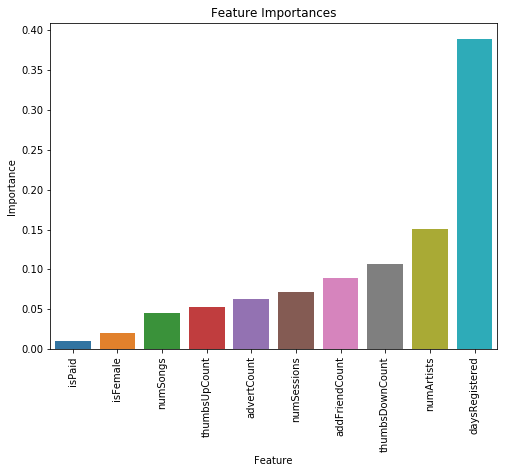

In [207]:
#Plot feature importance:
plt.figure(figsize=[8,6])
sns.barplot(data = df_features , x = 'feature', y='importance')
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');
plt.show()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
# You can take a look at my write up in the medium article within my Github repository.